<a href="https://colab.research.google.com/github/CesarRosales16/Urban-Sprawl-SV/blob/main/Expansion_Urbana_AMSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de la expansión urbana en el AMSS usando técnicas de Teledetección y Machine Learning


## Preparación del ambiente de desarrollo

Se instala GeoPandas ya que por el momento no forma parte de las dependencias incluidas por defecto en Google Colab.

In [ ]:
!pip install geopandas

Se importan las librerias necesarias.

In [ ]:
import ee 
import folium 
import pandas as pd
import geopandas as gpd 
import json
from google.colab import drive
import time 
import matplotlib.pyplot as plt

Se inicializan y autentican las librerias que lo requieren.

In [ ]:
# Trigger the EE authentication flow.
ee.Authenticate()

# Initialize the EE library.
ee.Initialize()

In [ ]:
# We mount drive to acces to our folders
drive.mount('/content/drive')

## Delimitación espacial

In [ ]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
# Load data from shapefile (.shp) located at GitHub
# https://github.com/CesarRosales16/Urban-Sprawl-SV
mun_datasource_url = 'https://raw.githubusercontent.com/CesarRosales16/Urban-Sprawl-SV/main/datasources/municipios-qgis/municipios_wgs84.shp'
mun_shp_path = '/vsicurl/' + mun_datasource_url
mun_data = gpd.read_file(mun_shp_path)
mun_data.head()

,fid,NOM_DPTO,COD_DPTO,NOM_MUN,COD_MUN,COD_MUN4,TASA_POBR,POBR_FISDL,PERIM_KM,AREA_KM2,POB_TOTAL,POB_HOMB,POB_MUJER,Shape_Leng,Shape_Area,geometry
0,1.0,CHALATENANGO,04,NUEVA CONCEPCION,16,0416,46.6,Pobreza Moderada,111.054433,343.809219,28625,13491,15134,1.015356,0.028779,"POLYGON ((-89.28916 14.24249, -89.28889 14.241..."
1,2.0,CHALATENANGO,04,AGUA CALIENTE,01,0401,57.3,Pobreza Alta,59.338583,128.497304,8261,3820,4441,0.541842,0.010761,"POLYGON ((-89.23636 14.27155, -89.23595 14.271..."
2,3.0,CHALATENANGO,04,LA PALMA,12,0412,52.4,Pobreza Alta,75.920713,150.504556,12235,5781,6454,0.696167,0.012609,"POLYGON ((-89.10319 14.35704, -89.10298 14.356..."
3,4.0,CHALATENANGO,04,SAN IGNACIO,25,0425,55.2,Pobreza Alta,50.199616,57.706536,8611,4055,4556,0.460160,0.004835,"POLYGON ((-89.08244 14.35526, -89.08251 14.355..."
4,5.0,CHALATENANGO,04,CITALA,04,0404,55.7,Pobreza Alta,59.140700,73.623486,4164,1964,2200,0.543241,0.006170,"POLYGON ((-89.34774 14.41833, -89.34478 14.418..."


epsg:4326


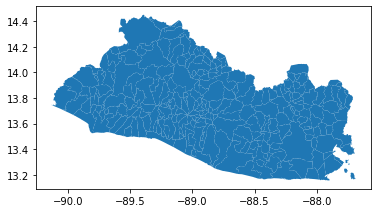

In [ ]:
# Set coordinate reference system to dataset (WGS84 = epsg:4326)
mun_data.crs = 'epsg:4326'
print(mun_data.crs)
mun_data.plot()

In [ ]:
# Create a new dataset based on AMSS municipalities
mun_amss = ['NEJAPA', 'TONACATEPEQUE', 'CUSCATANCINGO', 'APOPA', 'DELGADO', 'AYUTUXTEPEQUE', 'MEJICANOS', 'SAN SALVADOR',
'SAN MARTIN', 'ILOPANGO', 'SOYAPANGO', 'SAN MARCOS', 'ANTIGUO CUSCATLAN', 'SANTA TECLA']
amss_data = mun_data.loc[mun_data.NOM_MUN.isin(mun_amss)]

In [ ]:
# Create a new dataset based on aiditional municipalities, for our case Colon
mun_aditional = ['COLON']
mun_aditional_data = mun_data.loc[mun_data.NOM_MUN.isin(mun_aditional)]

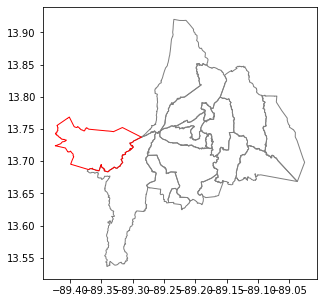

In [ ]:
# Plot amss and colon in a single map to check geometries
ax = amss_data.plot(figsize=(5,5), color='none', edgecolor='gray')
mun_aditional_data.plot(ax=ax, color='none', edgecolor='red')

In [ ]:
# Merge AMSS and aditional municipalities in a single dataframe for our ROI (Region Of Interest)
mun_roi = mun_amss + mun_aditional
roi_data = mun_data.loc[mun_data.NOM_MUN.isin(mun_roi)]

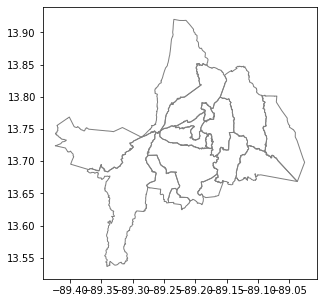

In [ ]:
# Check the CRS for the final df
print(roi_data.crs)
# Plot our ROI
roi_data.plot(figsize=(5,5), color='none', edgecolor='gray')

In [ ]:
# Geographic data for SV
sv_lon = -88.89653
sv_lat = 13.794185
sv_poi = ee.Geometry.Point(sv_lon, sv_lat)

In [ ]:
# Geographic data for AMSS
amss_lon = -89.214763
amss_lat = 13.723560
amss_poi = ee.Geometry.Point(amss_lon, amss_lat)

In [ ]:
# Create json from our ROI geodataframe
roi_json = json.loads(roi_data.to_json())

# Craete Google Earth Engine FeatureCollection from geojson
roi_fc = ee.FeatureCollection(roi_json)

# Create GEE Geometry from FeatureCollection
roi_geom = ee.Geometry(roi_fc.geometry())

## Recortando imágenes Landsat

In [ ]:
# Define cloud mask for Landsat 8 images
def cloudMaskL8(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 8 SR data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 8 SR image
  
  Return:
  -------
  cloudmasked Landsat 8 image
  '''
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = img.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)\
           .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  return img.updateMask(mask)    

In [ ]:
# Define cloud mask for Landsat 4/5/7 images
def cloudMaskL457(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 4/5/7 SR data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 4/5/7 SR image
  
  Return:
  -------
  cloudmasked Landsat 4/5/7 image
  '''
  # Get the pixel QA band.
  qa = img.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 5)\
                  .And(qa.bitwiseAnd(1 << 7))\
                  .Or(qa.bitwiseAnd(1 << 3))
  # Remove edge pixels that don't occur in all bands
  mask = img.mask().reduce(ee.Reducer.min())
  return img.updateMask(cloud.Not()).updateMask(mask)  

In [ ]:
# Function that retrieves Landsat Collection ID for a given year
def getLandsatCollectionId(year):
  if year >= 1985 and year <= 1999:
    return 'LT05'
  elif year >= 2000 and year <= 2013:
    return 'LE07'
  elif year >= 2014 and year <= 2021:
    return 'LC08'

In [ ]:
# Function that clips a single Landsat Image given landsat collection ID, a year, a roi and a porcentage of cloud contamination
def clipLandsatImage(year, landsat_id, cloud_contamination, roi):

  landsat_path = 'LANDSAT/' + landsat_id + '/C01/T1_SR'
  initial_date = str(year) + '-01-01'
  end_date = str(year) + '-12-31'

  landsat_collection = ee.ImageCollection(landsat_path)

  clipped_image = landsat_collection\
    .filterBounds(roi)\
    .filterDate(initial_date, end_date)\
    .filter(ee.Filter.lt('CLOUD_COVER', cloud_contamination))\
    .map(cloudMaskL8 if landsat_id == 'LC08' else cloudMaskL457)\
    .median()\
    .clip(roi)

  return clipped_image

In [ ]:
# Function that clips n Landsat Images in a range of years, given a cloud contamination percentage and a roi
def clipLandsatImagesInRange(initial_year, end_year, cloud_contamination, roi):
  clipped_images = []
  for year in range(initial_year, end_year + 1):
    landsat_id = getLandsatCollectionId(year)
    clipped_images.append(clipLandsatImage(year, landsat_id, cloud_contamination, roi_geom))
  return clipped_images

In [ ]:
# Function that clips n Landsat Images in a range of years, given a cloud contamination percentage and a roi
def clipLandsatImagesInRangeList(range_years, cloud_contamination, roi):
  clipped_images = []
  for year in range_years:
    landsat_id = getLandsatCollectionId(year)
    clipped_images.append(clipLandsatImage(year, landsat_id, cloud_contamination, roi_geom))
  return clipped_images

In [ ]:
#clipped_images = clipLandsatImagesInRange(initial_year=1992, end_year=2021, cloud_contamination=30, roi=roi_geom)

In [ ]:
# We define our years of interest for Landsat Imagery
landsat5_years = [1991, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
landsat7_years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
landsat8_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# Clip landsat images for given year, cloud contamination and ROI geometry
clipped_images_L5 = clipLandsatImagesInRangeList(landsat5_years, 20, roi_geom)
clipped_images_L7 = clipLandsatImagesInRangeList(landsat7_years, 20, roi_geom)
clipped_images_L8 = clipLandsatImagesInRangeList(landsat8_years, 20, roi_geom)

# Concatenate results in a global list 
years_of_interes = landsat5_years + landsat7_years + landsat8_years
clipped_images = clipped_images_L5 + clipped_images_L7 + clipped_images_L8

print('Number of clipped images:', len(clipped_images))

Number of clipped images: 30


## Clasificando las imágenes Landsat

### Preparación previa a la clasificación

In [ ]:
# Retrieving training points from GitHub
train_datasource_url = 'https://raw.githubusercontent.com/CesarRosales16/Urban-Sprawl-SV/main/datasources/train-data-1991/TrainCoverAMSSC.shp'
train_shp_path = '/vsicurl/' + train_datasource_url
train_data = gpd.read_file(train_shp_path)
train_data.head()

,Class,geometry
0,0,POINT (-89.14201 13.72003)
1,0,POINT (-89.12639 13.71928)
2,0,POINT (-89.13214 13.71711)
3,0,POINT (-89.14073 13.71269)
4,0,POINT (-89.14176 13.72445)


In [ ]:
# Create json from geodataframe
train_json = json.loads(train_data.to_json())

In [ ]:
#Importing training data
training = ee.FeatureCollection(train_json)

label = 'Class'
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']

In [ ]:
def classifyGivenImage(classifier, image, train_pct, training, label, bands):
  input = image.select(bands)

  train_image = input.sampleRegions(**{
      'collection': training,
      'properties': [label],
      'scale': 30
  })

  training_data = train_image.randomColumn()

  train_set = training_data.filter(ee.Filter.lessThan('random', train_pct))
  test_set = training_data.filter(ee.Filter.greaterThanOrEquals('random', train_pct))

  # Train our model with the given classifier for the train set
  model = classifier.train(train_set, label, bands)

  # Classify entire image
  classified_image = input.classify(model)

  #Validation:
  validated = test_set.classify(model)

  error_matrix = validated.errorMatrix(label, 'classification')
  overall_accuracy = error_matrix.accuracy().getInfo()
  kappa_index = error_matrix.kappa().getInfo()

  return classified_image, error_matrix.getInfo(), overall_accuracy, kappa_index

In [ ]:
def classifyMultipleImages(classifier, images, train_pct, training, label, bands):
  classified_images = []
  error_matrices = []
  overall_accuracies = []
  kappa_indexes = []
  for image in images:
    classified, error_matrix, overall_accuracy, kappa_index = classifyGivenImage(classifier, image, train_pct, training, label, bands)
    classified_images.append(classified)
    error_matrices.append(error_matrix)
    overall_accuracies.append(overall_accuracy)
    kappa_indexes.append(kappa_index)
  return classified_images, error_matrices, overall_accuracies, kappa_indexes

### Random Forest

In [ ]:
rf_classifier = ee.Classifier.smileRandomForest(10)
classified_images, error_matrices, overall_accuracies, kappa_indexes = classifyMultipleImages(rf_classifier, clipped_images, 0.80, training, label, bands)

In [ ]:
result_dict = {
    'year': years_of_interes,
    'overall_accuracy': overall_accuracies,
    'kappa_index': kappa_indexes
}

result_df = pd.DataFrame(result_dict)
result_df.head()

,year,overall_accuracy,kappa_index
0,1991,0.936170,0.883278
1,1993,0.975309,0.956545
2,1994,0.947917,0.895425
3,1995,0.961039,0.910811
4,1996,0.968085,0.933818


In [ ]:
result_df.describe()

,year,overall_accuracy,kappa_index
count,30.000000,30.000000,30.000000
mean,2006.466667,0.952429,0.908389
std,8.861903,0.021160,0.040113
min,1991.000000,0.901099,0.821140
25%,1999.250000,0.943314,0.886315
50%,2006.500000,0.953322,0.910809
75%,2013.750000,0.966098,0.934933
max,2021.000000,0.989583,0.981363


In [ ]:
print(result_df)

    year  overall_accuracy  kappa_index
0   1991          0.936170     0.883278
1   1993          0.975309     0.956545
2   1994          0.947917     0.895425
3   1995          0.961039     0.910811
4   1996          0.968085     0.933818
5   1997          0.915888     0.848609
6   1998          0.962963     0.932815
7   1999          0.978495     0.959670
8   2000          0.989583     0.981363
9   2001          0.965517     0.936926
10  2002          0.975904     0.951632
11  2003          0.957447     0.912923
12  2004          0.952941     0.910808
13  2005          0.951456     0.913197
14  2006          0.925532     0.868924
15  2007          0.941176     0.881349
16  2008          0.916667     0.832907
17  2009          0.963415     0.930860
18  2010          0.952381     0.897748
19  2011          0.953704     0.899310
20  2012          0.950980     0.905921
21  2013          0.948454     0.898344
22  2014          0.966292     0.935304
23  2015          0.946809     0.909056


In [ ]:
result_df.to_csv('class_rf_results.csv')

### CART

In [ ]:
rf_classifier = ee.Classifier.smileCart()
classified_images, error_matrices, overall_accuracies, kappa_indexes = classifyMultipleImages(rf_classifier, clipped_images, 0.80, training, label, bands)

In [ ]:
result_dict = {
    'year': years_of_interes,
    'overall_accuracy': overall_accuracies,
    'kappa_index': kappa_indexes
}

result_df = pd.DataFrame(result_dict)
result_df.head()

In [ ]:
result_df.describe()

In [ ]:
print(result_df)

In [ ]:
result_df.to_csv('class_cart_results.csv')

### SVM

In [ ]:
rf_classifier = ee.Classifier.libsvm()
classified_images, error_matrices, overall_accuracies, kappa_indexes = classifyMultipleImages(rf_classifier, clipped_images, 0.80, training, label, bands)

In [ ]:
result_dict = {
    'year': years_of_interes,
    'overall_accuracy': overall_accuracies,
    'kappa_index': kappa_indexes
}

result_df = pd.DataFrame(result_dict)
result_df.head()

In [ ]:
result_df.describe()

In [ ]:
print(result_df)

In [ ]:
result_df.to_csv('class_svm_results.csv')

## Visualización de mapas

In [ ]:
def mapSingleLayer(layer, layar_vis_params, layer_name, folium_width='100%', folium_height=None):

  f = folium.Figure(width=folium_width, height=folium_height)

  my_map = folium.Map(location=[amss_lat, amss_lon], zoom_start=10, max_bounds=True, min_zoom=1.5).add_to(f)

  # Boundaries layer for our ROI
  my_map.add_ee_layer(roi_fc.draw('006600', 3, 2), {}, 'ROI Boundaries')

  # Layer of interest
  my_map.add_ee_layer(layer, layar_vis_params, layer_name)
  
  my_map.add_child(folium.LayerControl())

  display(my_map)

In [ ]:
def mapClippedAndClassifiedForAYear(year, years, clipped, clipped_params, classified, classified_params, folium_width='100%', folium_height=None):

  f = folium.Figure(width=folium_width, height=folium_height)

  my_map = folium.Map(location=[amss_lat, amss_lon], zoom_start=10, max_bounds=True, min_zoom=1.5).add_to(f)

  # Boundaries layer
  my_map.add_ee_layer(roi_fc.draw('006600', 3, 2), {}, 'ROI Boundaries')
  
  # Get index for desired year
  index = years.index(year)

  # Clipped Image layer
  my_map.add_ee_layer(clipped[index], clipped_params, 'Landsat ' + str(year))
  
  # Classified image mayer
  my_map.add_ee_layer(classified[index], classified_params, 'Classification ' + str(year))

  # Add a layer control panel to the map
  my_map.add_child(folium.LayerControl())

  display(my_map)

In [ ]:
# Set visualization parameters for Landsat 8 images
vis_params_L8 = {
    'bands':['B4', 'B3', 'B2'], 
    'min': 0, 
    'max': 3000, 
    'gamma': 1.4
}

# Set visualization parameters for Landsat 4/5/7 images
vis_params_L457 = {
    'bands':['B3', 'B2', 'B1'], 
    'min': 0, 
    'max': 3000, 
    'gamma': 1.4
}

# Define palette for the clasification
land_cover_palette = [
                      '#E31A1C', # urban (0)
                      '#005A32', # land  (1)
                      '#0C2C84', # water (2)
]

# Set visualization parameters for classification layers
land_cover_params = {
    'palette': land_cover_palette, 
    'min': 0, 
    'max': 2
}

In [ ]:
mapClippedAndClassifiedForAYear(1992, years_of_interes, clipped_images, vis_params_L457, classified_images, land_cover_params, '75%', 500)

## Capas adicionales para modelo de predicción


In [ ]:
# Digital Elevation Model (DEM)
dem = ee.Image("USGS/SRTMGL1_003").clip(roi_geom)
dem_vis_params = {'min': 0, 'max': 6000}
mapSingleLayer(dem, dem_vis_params, 'DEM AMSSS', '75%', 500)

In [ ]:
# Slope
elevation = dem.select('elevation')
slope = ee.Terrain.slope(elevation);
slope_vis_params = {'min': 0, 'max': 60}
mapSingleLayer(slope, slope_vis_params, 'Slope AMSSS', '75%', 500)

In [ ]:
# Aspect
aspect = ee.Terrain.aspect(elevation);
aspect_vis_params = {'min': 0, 'max': 359.99}
mapSingleLayer(aspect, aspect_vis_params, 'Aspect AMSSS', '75%', 500)

In [ ]:
# Hillshade
terrain = ee.Terrain.products(dem)
hillshade = terrain.select('hillshade')
hillshade_vis_params = {min: 0, max: 255}
mapSingleLayer(hillshade, hillshade_vis_params, 'Hillshade AMSSS', '75%', 500)

## Exportando imagenes como GeoTIFF

In [ ]:
# Path where geotiff files are saved
drive_path = "GeoTIFF-Molusce-Final"

In [ ]:
# Export the image, specifying scale and region.
def exportImageToDrive(image_to_export, name, drive_folder, image_scale, region, crs):

  task = ee.batch.Export.image.toDrive(**{
      'image': image_to_export,
      'description': name,
      'folder': drive_folder,
      'crs': crs,
      'scale': image_scale,
      'region': region
  })
  task.start()

  while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(10)

In [ ]:
def exportImagesInRangeToDrive(images, range_list):
  for i in range(len(range_list)):
    name = 'LC01T1SR_RF_' + str(range_list[i])
    print("Exporting", name)
    exportImageToDrive(images[i], name, drive_path, 30, roi_geom, 'EPSG:4326')

In [ ]:
exportImageToDrive(classified_images[0], 'LULC_RF_1991', drive_path, 30, roi_geom, 'EPSG:4326')

Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).
Polling for task (id: OMFGDYMH2ZYN5WBGUJSY464D).


In [ ]:
exportImageToDrive(classified_images[13], 'LULC_RF_2005', drive_path, 30, roi_geom, 'EPSG:4326')

Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).
Polling for task (id: AXFOHEQGQQTW5ZIKGAUEYNWN).


In [ ]:
exportImageToDrive(classified_images[27], 'LULC_RF_2019', drive_path, 30, roi_geom, 'EPSG:4326')

Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).
Polling for task (id: DPJG2BBZDPG76PCQNFSU62VH).


In [ ]:
exportImagesInRangeToDrive(classified_images, years_of_interes)

Exporting LC01T1SR_RF_1991
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Polling for task (id: MWSMFJ57P2Y7X2ZEPF36LNEK).
Exporting LC01T1SR_RF_1993
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for task (id: FUAFHW5NPCC7EAD4PUPSOTJU).
Polling for tas

## Resultados